In [ ]:
#default_exp augment.kornia

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#export
from fastai.vision.all import *
import PIL
import kornia as K
import torchvision.transforms.functional as TTF
from PIL import Image

In [ ]:
to_tensor = lambda img: TTF.to_tensor(img)
to_img    = lambda tensor: TTF.to_pil_image(tensor)
size      = (270,150)
hstack    = lambda img1,img2: PIL.Image.fromarray(np.hstack((array(img1), array(img2))))

fname = '../assets/imgs/atomic-blonde.jpg'
img   = PIL.Image.open(fname).resize(size)

In [ ]:
#export
class KorniaBase(RandTransform):
    '''
    Pass in a kornia function, module, list of modules, or nn.Sequential
    containers to `kornia_tfm`.
    If passing functions, you can pass in function arguments as keyword
    args (**kwargs), which can also be random number generators.
    
    Example
    =======
    * KorniaWrapper(kornia.adjust_hue, hue_factor=1.2)
    * KorniaWrapper(kornia.augmentation.ColorJitter(.2,.3,.1,.2))
    * KorniaWrapper(nn.Sequential(*[kornia.augmentation.ColorJitter()]))
    * KorniaWrapper([
        kornia.augmentation.ColorJitter(.2),
        kornia.augmentation.RandomMotionBlur(3, 5., 1.)
    ]))
    '''
    order = 10
    split_idx = 0
    def __init__(self, kornia_tfm=None,p=1., **kwargs):
        super().__init__(p=p)
        self.tfm = kornia_tfm
        self.input_kwargs = kwargs
        self.call_kwargs  = dict.fromkeys(kwargs)
        self._pipe = Pipeline([ToTensor(), IntToFloatTensor()])
        self.process_tfm()
    
    def before_call(self, b, split_idx, verbose=False):
        'Compute `p` of applying transform, process input kwargs if applicable'
        self.do = self.p==1. or random.random() < self.p
        for arg,value in self.input_kwargs.items():
            if hasattr(value, '__call__'): self.call_kwargs[arg] = value()
            else: self.call_kwargs[arg] = value
    
    def process_tfm(self):
        'Process the input `kornia_tfm` argument and make it callable'
        if hasattr(self.tfm, 'forward') and hasattr(self.tfm, '__iter__'):
            pass                                ## -- nn.Sequential

        elif hasattr(self.tfm, 'forward') and type(self.tfm) is not type:      
            self.tfm = nn.Sequential(self.tfm)  ## -- Kornia module (called)
        
        elif hasattr(self.tfm, 'forward') and type(self.tfm) is type:      
            #self.tfm = nn.Sequential(self.tfm)  ## -- Kornia module (uncalled)
            pass
        
        elif isinstance(self.tfm, list):
            self.tfm = nn.Sequential(*self.tfm) ## -- list of Kornia Modules
    
    def _encode(self, o:TensorImage): return TensorImage(self.tfm(o, **self.call_kwargs)) if self.do else o
    def encodes(self, o:torch.Tensor): return self._encode(o)
    def encodes(self, o:Image.Image):  return self._encode(self._pipe(PILImage(o)))
    def encodes(self, o:TensorImage):  return self._encode(o)
    def encodes(self, o:PILImage):     return self._encode(self._pipe(o))
    def encodes(self, o:(str,Path)):   return self._encode(self._pipe(PILImage.create(o)))
    def encodes(self, o:(TensorCategory,TensorMultiCategory)): return o
    
    def __repr__(self): return self.tfm.__repr__()

In [ ]:
from nbdev.showdoc import *

In [ ]:
show_doc(KorniaBase)

<h2 id="KorniaBase" class="doc_header"><code>class</code> <code>KorniaBase</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>KorniaBase</code>(**`kornia_tfm`**=*`None`*, **`p`**=*`1.0`*, **\*\*`kwargs`**) :: `RandTransform`

```
Pass in a kornia function, module, list of modules, or nn.Sequential
containers to `kornia_tfm`.
If passing functions, you can pass in function arguments as keyword
args (**kwargs), which can also be random number generators.

Example
=======
* KorniaWrapper(kornia.adjust_hue, hue_factor=1.2)
* KorniaWrapper(kornia.augmentation.ColorJitter(.2,.3,.1,.2))
* KorniaWrapper(nn.Sequential(*[kornia.augmentation.ColorJitter()]))
* KorniaWrapper([
    kornia.augmentation.ColorJitter(.2),
    kornia.augmentation.RandomMotionBlur(3, 5., 1.)
]))
```

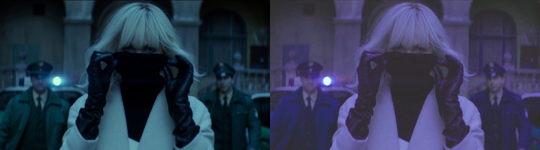

In [ ]:
tfm = KorniaBase(K.augmentation.ColorJitter(0.2,0.3,0.1,0.2))
hstack(img, to_img(tfm(img, split_idx=0)[0]))

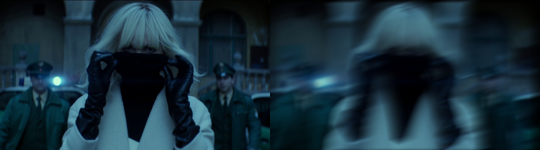

In [ ]:
tfm = KorniaBase(
        K.augmentation.RandomMotionBlur(kernel_size = (3,25),
                                        angle       = (15., 15.),
                                        direction   = (-1., 1.))
)
hstack(img, to_img(tfm(img, split_idx=0)[0]))

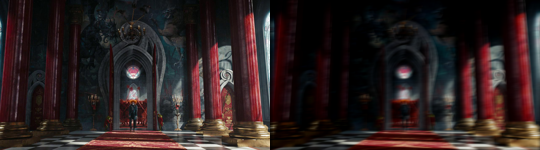

In [ ]:
img = PIL.Image.open('../assets/imgs/alice-in-wonderland.jpg').resize(size)
tfm = KorniaBase([
    K.augmentation.ColorJitter(.1, .1, .1, .1),
    K.augmentation.RandomMotionBlur((7,7), (5.,15.), (-1.,1.))
])
hstack(img, to_img(tfm(img, split_idx=0)[0]))

### Class Interface for Kornia Transforms

Provided below are common Kornia transforms wrapped inside a subclass of `KorniaBase`. We expose the parameters of every transform in the wrapper class. 

Kornia's transformations do not have a common API -- some of them accept `p` parameters whereas some don't. By wrapping them in a `KorniaBase` subclass and passing the `p` parameters appropriately (either in the kornia transform or `KorniaBase` constructor), we have a common API that can be easily called when constructing a `DataBlock`

In [ ]:
#export
class MotionBlur(KorniaBase):
    'kornia.augmentation.RandomMotionBlur'
    order=110
    def __init__(self, p=.2, kernel_size=(3,21), angle=(15., 15.), direction=(-1., 1.)):
        super().__init__(
            kornia_tfm = K.augmentation.RandomMotionBlur(kernel_size = kernel_size,
                                                         angle       = angle,
                                                         direction   = direction),
            p=p)

In [ ]:
#export
class ColorJitter(KorniaBase):
    'kornia.augmentation.ColorJitter'
    order=20
    def __init__(self, p=.2, jitter_brightness=.1, jitter_contrast=.1, jitter_saturation=(.1, .9), jitter_hue=.2):
        super().__init__(
            kornia_tfm = K.augmentation.ColorJitter(brightness = jitter_brightness,
                                                    contrast   = jitter_contrast,
                                                    saturation = jitter_saturation,
                                                    hue        = jitter_hue),
            p=p
        )

In [ ]:
show_doc(ColorJitter)

<h2 id="ColorJitter" class="doc_header"><code>class</code> <code>ColorJitter</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ColorJitter</code>(**`p`**=*`0.2`*, **`jitter_brightness`**=*`0.1`*, **`jitter_contrast`**=*`0.1`*, **`jitter_saturation`**=*`(0.1, 0.9)`*, **`jitter_hue`**=*`0.2`*) :: [`KorniaBase`](/fastai_amalgam/augment_kornia.html#KorniaBase)

```
kornia.augmentation.ColorJitter
```

In [ ]:
#export
class RandomRotation(KorniaBase):
    'kornia.augmentation.RandomRotation'
    order=13
    def __init__(self, p=.2, rotate_degrees=10):
        super().__init__(
            kornia_tfm = K.augmentation.RandomRotation(rotate_degrees),
            p=p
        )

In [ ]:
show_doc(RandomRotation)

<h2 id="RandomRotation" class="doc_header"><code>class</code> <code>RandomRotation</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>RandomRotation</code>(**`p`**=*`0.2`*, **`rotate_degrees`**=*`10`*) :: [`KorniaBase`](/fastai_amalgam/augment_kornia.html#KorniaBase)

```
kornia.augmentation.RandomRotation
```

In [ ]:
#export
class MedianBlur(KorniaBase):
    'kornia.filters.MedianBlur'
    order=14
    def __init__(self, p=.2, kernel_size=(5,5), p_median_blur=.2):
        super().__init__(
            kornia_tfm = K.filters.MedianBlur(kernel_size=kernel_size),
            p=p
        )

In [ ]:
show_doc(MedianBlur)

<h2 id="MedianBlur" class="doc_header"><code>class</code> <code>MedianBlur</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>MedianBlur</code>(**`p`**=*`0.2`*, **`kernel_size`**=*`(5, 5)`*, **`p_median_blur`**=*`0.2`*) :: [`KorniaBase`](/fastai_amalgam/augment_kornia.html#KorniaBase)

```
kornia.filters.MedianBlur
```

In [ ]:
#export
class HFlip(KorniaBase):
    'kornia.augmentation.RandomHorizontalFlip'
    order=15
    def __init__(self, p=.5):
        super().__init__(
            kornia_tfm = K.augmentation.RandomHorizontalFlip(p=p)
        )

In [ ]:
show_doc(HFlip)

<h2 id="HFlip" class="doc_header"><code>class</code> <code>HFlip</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>HFlip</code>(**`p`**=*`0.5`*) :: [`KorniaBase`](/fastai_amalgam/augment_kornia.html#KorniaBase)

```
kornia.augmentation.RandomHorizontalFlip
```

In [ ]:
#export
class VFlip(KorniaBase):
    'kornia.augmentation.RandomVerticalFlip'
    order=16
    def __init__(self, p=.5):
        super().__init__(
            kornia_tfm = K.augmentation.RandomVerticalFlip(p=p)
        )

In [ ]:
show_doc(VFlip)

<h2 id="VFlip" class="doc_header"><code>class</code> <code>VFlip</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>VFlip</code>(**`p`**=*`0.5`*) :: [`KorniaBase`](/fastai_amalgam/augment_kornia.html#KorniaBase)

```
kornia.augmentation.RandomVerticalFlip
```

In [ ]:
#export
class RandomGrayscale(KorniaBase):
    'kornia.augmentation.RandomGrayscale'
    order=17
    def __init__(self, p=.2):
        super().__init__(
            kornia_tfm=K.augmentation.RandomGrayscale(p=p)
        )

In [ ]:
show_doc(RandomGrayscale)

<h2 id="RandomGrayscale" class="doc_header"><code>class</code> <code>RandomGrayscale</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>RandomGrayscale</code>(**`p`**=*`0.2`*) :: [`KorniaBase`](/fastai_amalgam/augment_kornia.html#KorniaBase)

```
kornia.augmentation.RandomGrayscale
```

In [ ]:
#export
class RandomPerspective(KorniaBase):
    'kornia.augmentation.RandomPerspective'
    order=18
    def __init__(self, p=.2, distortion_scale=0.5, interpolation='BILINEAR'):
        super().__init__(
            kornia_tfm=K.augmentation.RandomPerspective(
                p=p, distortion_scale=distortion_scale,
                interpolation=interpolation)
        )

In [ ]:
show_doc(RandomPerspective)

<h2 id="RandomPerspective" class="doc_header"><code>class</code> <code>RandomPerspective</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>RandomPerspective</code>(**`p`**=*`0.2`*, **`distortion_scale`**=*`0.5`*, **`interpolation`**=*`'BILINEAR'`*) :: [`KorniaBase`](/fastai_amalgam/augment_kornia.html#KorniaBase)

```
kornia.augmentation.RandomPerspective
```

In [ ]:
dblock = DataBlock(
    blocks     = ImageBlock,
    get_items  = get_image_files,
    get_x      = Pipeline([PILImage.create]),
    item_tfms  = [Resize(size=(224,224), method=ResizeMethod.Squish, pad_mode=PadMode.Zeros)],
    batch_tfms = [
        ColorJitter(p=0.5),
        MotionBlur(p=0.5),
        HFlip(p=0.5),
        VFlip(p=0.5),
        RandomGrayscale(p=0.25),
        Normalize.from_stats(*imagenet_stats)
    ]
)

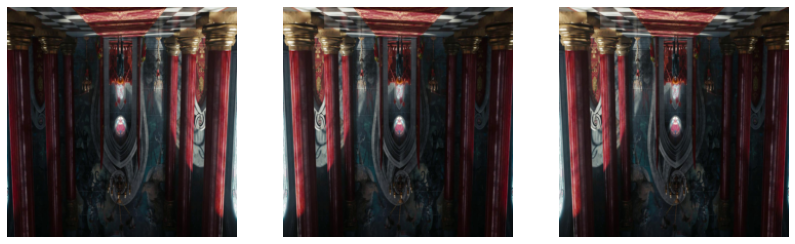

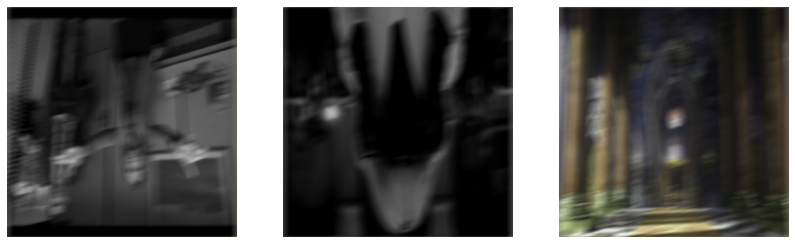

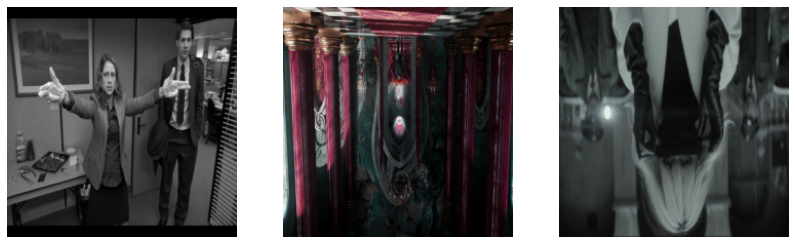

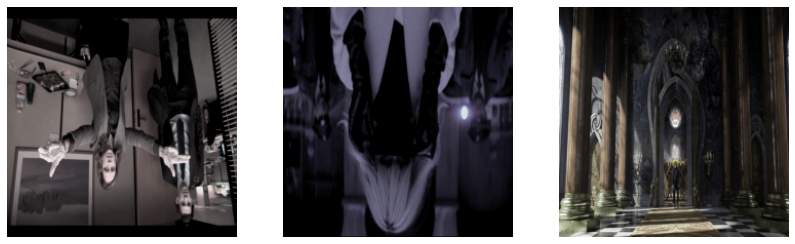

In [ ]:
dls = dblock.dataloaders('../assets/imgs/', bs=3)
dls.show_batch(figsize=(14,14), unique=True)
dls.show_batch(figsize=(14,14))
dls.show_batch(figsize=(14,14))
dls.show_batch(figsize=(14,14))

### Export

In [ ]:
#hide
from nbdev.export import *
notebook2script('07_augment_kornia.ipynb')

Converted 07_augment_kornia.ipynb.
